In [1]:
#Packages.
from scipy.integrate import odeint      #ODE calculations for SIR

#Modules.
import Functions as fun

%matplotlib inline
%pylab inline

#Plotting settings.
rc('font', size = 18)
rc('lines', linewidth = 2)
myColors = plt.cm.Spectral(concatenate([arange(0,0.35,1/12.),arange(0.6,1.05,1/12.)]))

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Parameters.
R0 = 1.4              #Basic reproduction number.
gamma = 5.0/7.0      #Waning immunity rate. Mean beta distribution = alpha/(alpha+beta) = 10/12
Vc = 0.2              #Vaccine coverage.
Ve = 0.5              #Vaccine efficiency.

Years = range(0,10000)
sweepVc = arange(0,0.41,0.01)

In [3]:
#Initialise output vectors.
import random as rnd

def timeseriesStochastic(R0,Vc,Ve,years):
    
    #Add burn-in period.
    years = range(0,len(years)+50)
    
    #Initialise output vectors.
    waningRates = [1.0]
    timeseriesFinal = [0.0]     #Fraction infected during seasonal epidemic.
    timeseriesSusc = [1.0]   #Fraction susceptibles at start of season. 
    
    timeseriesFinalNoWaning = [0.0]
    
    for year in years:
        
        gamma = rnd.betavariate(5,2)
        
        s0 = timeseriesSusc[-1]
        finalSize, susceptibility = fun.giveNextSusceptibility(R0,gamma,Vc,Ve,s0)

        waningRates += [1.0-gamma]
        timeseriesFinal += [ finalSize ]
        timeseriesSusc += [ susceptibility ]

    return waningRates[51:], timeseriesFinal[51:], timeseriesSusc[51:]

In [4]:
#Function for calculation Pearson's correlation between two timeseries.
from scipy import stats

def giveTimeCorrelation(x,y):
    offset = 10
    length = len(x)
    corr = [stats.pearsonr(x[offset:-offset],y[offset+shift:length+shift-offset]) 
            for shift in range(offset)]
    return corr

In [ ]:
#Deterministic runs.

corrSuscDet = []

for Vc in sweepVc:
    print Vc,
    finDet, suscDet = fun.timeseriesDeterministic(R0, gamma, Vc, Ve, Years)
    
    correlation = giveTimeCorrelation(suscDet[:-1],finDet[1:]) 

    corrSuscDet += [ (transpose(correlation)[0][0], transpose(correlation)[0][1]) ]

In [5]:
#Calculating Pearson's correlation between final sizes and waning immunity rate for different Vc.

corrSusc = []
corrWaning = []
corrFin = []

for Vc in sweepVc:
    print Vc,
    waningRates, finStoch, suscStoch = timeseriesStochastic(R0, Vc, Ve, Years)
    
    correlation = giveTimeCorrelation(suscStoch[:-1],finStoch[1:]) 

    corrSusc += [ (transpose(correlation)[0][0], transpose(correlation)[0][1],
                              sum(transpose(correlation)[0][2:])) ]
    
    correlation = giveTimeCorrelation(finStoch[:-1],finStoch[1:])
    
    corrFin += [ (transpose(correlation)[0][0], transpose(correlation)[0][1],
                              sum(transpose(correlation)[0][2:])) ]
    
    correlation = giveTimeCorrelation(waningRates[:-1],finStoch[1:]) 

    corrWaning += [ (transpose(correlation)[0][0], transpose(correlation)[0][1],
                              transpose(correlation)[0][2]) ]

0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4


In [7]:
#Write data for re-use.
fun.writeData('data/correlationSusceptibilityDeterministic',corrSuscDet)

fun.writeData('data/correlationSusceptibility',corrSusc)
fun.writeData('data/correlationFinalSize',corrFin)
fun.writeData('data/correlationWaning',corrWaning)

In [ ]:
#Read data.
corrSuscDet = fun.readData('data/correlationSusceptibilityDeterministic')

corrSusc = fun.readData('data/correlationSusceptibility')
corrWaning = fun.readData('data/correlationWaning')

In [9]:
#Generate timeseries with and without vaccination.

waningRates, finStoch, suscStoch = timeseriesStochastic(R0, 0.0, Ve, range(0,5000))
waningRatesVac, finStochVac, suscStochVac = timeseriesStochastic(R0, 0.25, Ve, range(0,10000))

In [22]:
def plotLinearRegression(ax,susc,fin):
    
    #Discard years with no outbreak.
    if False:
        susc = [x for x,y in zip(susc,fin) if y > 0.001] 
        fin = [x for x in fin if x > 0.001]
    
    #Compare last year susceptibility with current final size.
    xs = susc[:-2]
    ys = fin[2:]
    
    #Or ...  last year's final size with current final size.
    #xs = fin[:-1]
    #ys = fin[1:]
    
    ax.scatter(xs,ys, s = 5, lw = 0, color = myColors[10])
    
    print '(rho, p-value) = ' + str(stats.pearsonr(xs,ys))
    
    #Do linear fitting.
    fit = polyfit(xs,ys,1)
    function = np.poly1d(fit) 
    
    xs = arange(min(xs),max(xs),0.001)
    ax.plot(xs, function(xs), color = 'black')
    
    ax.set_xlim([0.4,1.0])
    ax.set_xticks([0.4,0.6,0.8,1.0])
    
    fun.removeFrame(ax)
    

In [23]:
def plotCorrelates(ax,correlations):
    ax.plot(sweepVc,len(sweepVc)*[0], '--', color = 'black', lw = 1)
    
    ax.plot(sweepVc,transpose(correlations)[0], color = myColors[8], label = 'Current year\'s susceptibility') 
    ax.plot(sweepVc,transpose(correlations)[1], color = myColors[10], label = 'Last year\'s susceptibility',zorder = 3)
    #ax.plot(sweepVc,transpose(correlations)[2], color = myColors[4], label = 'Year before last year', zorder = 2)
    
    ax.set_xlim(0,0.4)
    ax.set_xticks([0,0.1,0.2,0.3,0.4])
    
    ax.set_ylim(-0.3,1.0)
    
    ax.set_xlabel('Vaccination coverage', fontsize = 22)
    ax.set_ylabel('Correlation with\n infection attack rate', fontsize = 22)

    #ax.legend(loc = 1, fontsize = 13, frameon = False)
    text(0.47,0.85,'Susceptibility in current year',transform=ax.transAxes, color = myColors[8], fontsize = 20)
    text(0.05,0.35,'Susceptibility in previous year',transform=ax.transAxes, color = myColors[10], fontsize = 20)
    
    fun.removeFrame(ax)

(rho, p-value) = (-0.24320369224241326, 3.322482009207225e-68)
(rho, p-value) = (0.12838905925448235, 5.1649841441756617e-38)


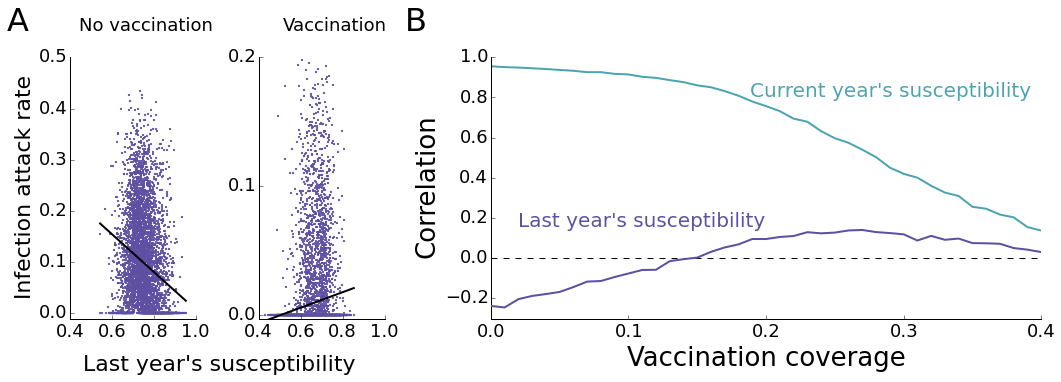

In [24]:
import matplotlib.gridspec as gridspec

fig = figure(figsize=(15,5))
gs = gridspec.GridSpec(1,2,width_ratios=[4,7])

gs0 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs[0], wspace = 0.5)

axes = [subplot(gs0[0]), subplot(gs0[1]),subplot(gs[1])]

plotLinearRegression(axes[0],suscStoch,finStoch)
plotLinearRegression(axes[1],suscStochVac,finStochVac)

plotCorrelates(axes[2],corrSusc)

axes[0].set_ylim([-0.01,0.5])
axes[1].set_ylim([-0.003,0.2])
axes[1].set_yticks([0,0.1,0.2])

text(0.1,-0.2,'Susceptibility in previous year',transform=axes[0].transAxes, fontsize = 22)
axes[0].set_ylabel('Infection attack rate', fontsize = 22)

text(0.6,1.1,'No vaccination', ha='center', fontsize = 18, transform=axes[0].transAxes)
text(0.6,1.1,'Vaccination', ha='center', fontsize = 18, transform=axes[1].transAxes)

text(-0.7,1.1,'A', fontsize = 32, transform=axes[0].transAxes)
text(-0.2,1.1,'B', fontsize = 32, transform=axes[2].transAxes)


tight_layout()

show()


#Save figure.
if False:
    fig.savefig('figures/correlation.eps',bbox_inches='tight')
    fig.savefig('figures/correlation.png',bbox_inches='tight')